# ARIMA MODEL

### SETUP

In [1]:
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.metrics import r2_score as r2
from sklearn.metrics import mean_squared_error as mse

from itertools import product

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
plt.rcParams['figure.figsize'] = [15, 7]

In [3]:
def optimize_ARIMA(endog,exog, order_list):
    """
        Return dataframe with parameters and corresponding AIC
        
        order_list - list with (p, d, q) tuples
        endog - the observed variable
    """
    
    results = []
    
    for order in tqdm_notebook(order_list):
        try: 
            model = ARIMA(endog, exog, order=order).fit()
        except:
            continue
            
        aic = model.aic
        mse = model.mse
        results.append([order, aic, mse])

    result_df = pd.DataFrame(results)
    result_df.columns = ["(p, d, q)", "AIC", "MSE"]
    #Sort in ascending order, lower MSE is better
    result_df = result_df.sort_values(by='MSE', ascending=True).reset_index(drop=True)
    
    return result_df

### DATA PREPROCESSING

In [4]:
# Load data
xau = pd.read_csv(r"C:\Users\GRACE ESTRADA\OneDrive\Desktop\XAUUSD.csv", parse_dates = ['Date'])

In [5]:
# Set index to date
xau = xau.sort_values('Date', ascending = True)
xau = xau.set_index('Date')

In [6]:
# Replace 0 values with 0.00001 to avoid issues during transformation
xau[xau < 0] = 0.00001

In [7]:
# Ensure that the frequency is set to business days
xau = xau.asfreq('B')

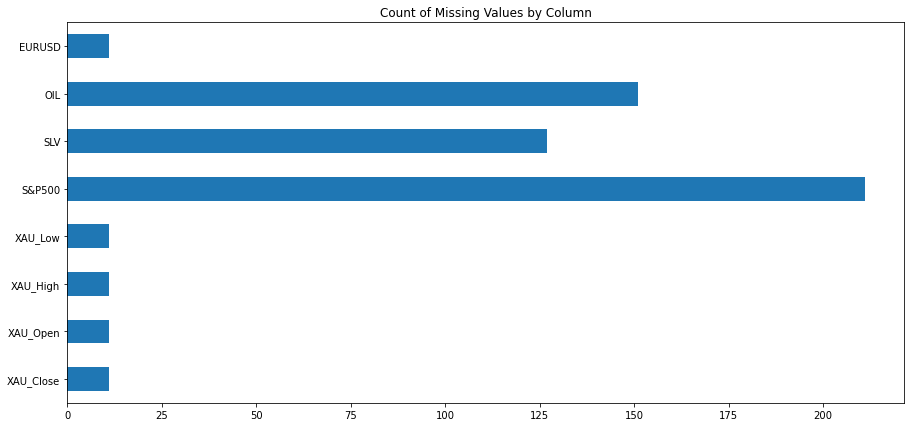

In [8]:
# Plot missing values
xau.isna().sum().plot(kind = 'barh')

plt.title('Count of Missing Values by Column')
plt.show()

In [9]:
# Fill in missing values with forward fill
xau = xau[1:].ffill()

# Ensure that there are no more missing values
assert xau.isna().sum().sum() == 0

### STATISTICAL TESTS

PRIOR TRANSFORMATION

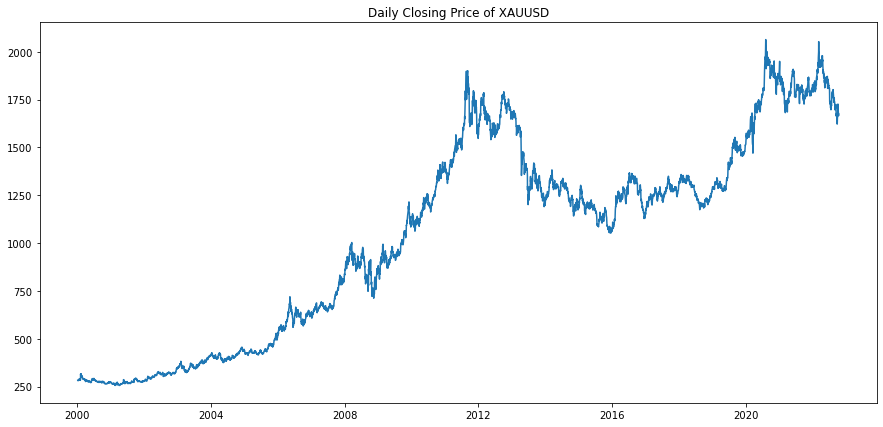

In [10]:
# Plot of XAU Closing Price

plt.plot(xau['XAU_Close'])
plt.title('Daily Closing Price of XAUUSD')
plt.show()

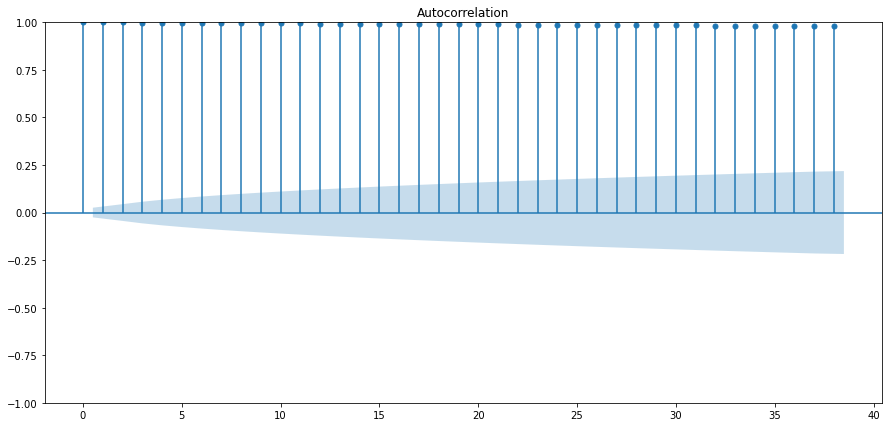

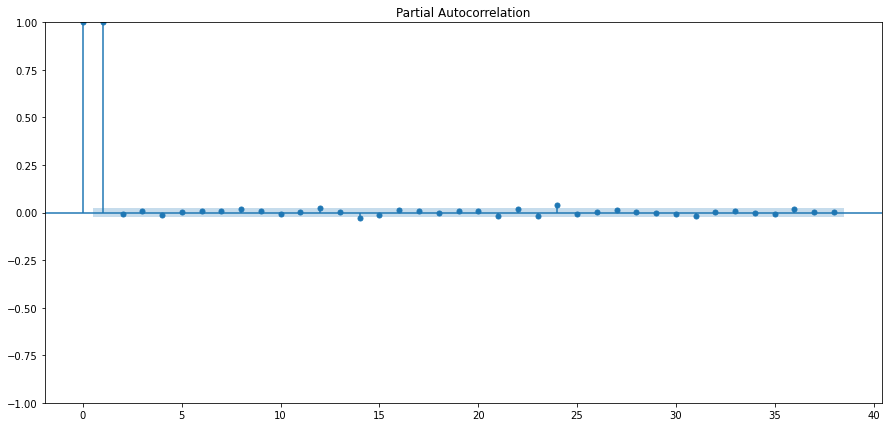

In [11]:
# Plot ACF and PACF prior to transformation

plot_acf(xau['XAU_Close']);
plot_pacf(xau['XAU_Close']);

In [12]:
# AdFuller Test prior to Transformation

ad_fuller_result = adfuller(xau['XAU_Close'])

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -1.0706089836469215
p-value: 0.7266492896560852


TRANSFORMATION

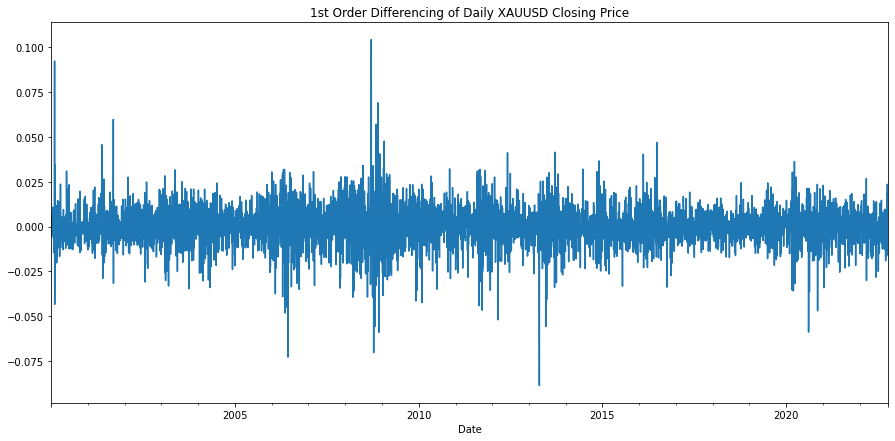

In [13]:
# 1st order of differencing
XAU_diff = np.log(xau['XAU_Close']).diff()

XAU_diff.plot()
plt.title('1st Order Differencing of Daily XAUUSD Closing Price')
plt.show()

In [14]:
# AdFuller Test after transformation

ad_fuller_result_D1 = adfuller(XAU_diff[1:])

print(f'ADF Statistic: {ad_fuller_result_D1[0]}')
print(f'p-value: {ad_fuller_result_D1[1]}')

ADF Statistic: -77.81468158349843
p-value: 0.0


LAG VALUES

In [15]:
xau_lag = xau[['XAU_High', 'XAU_Low', 'S&P500', 'SLV', 'OIL', 'EURUSD']].shift(1)
xau_lag.insert(0, 'XAU_Close', xau['XAU_Close'])
xau_lag.insert(1, 'XAU_Open', xau['XAU_Open'])
xau_lag = xau_lag[1:]
xau_lag = xau_lag.rename(columns = {'XAU_High': 'XAU_High_lag1',
                          'XAU_Low': 'XAU_Low_lag1',
                          'S&P500': 'S&P500_lag1',
                          'SLV' : 'SLV_lag1',
                          'OIL': 'OIL_lag1',
                          'EURUSD': 'EURUSD_lag'})

xau = xau[1:]

xau

,XAU_Close,XAU_Open,XAU_High,XAU_Low,S&P500,SLV,OIL,EURUSD
Date,,,,,,,,
2000-01-05,281.00,281.50,281.00,281.00,1402.10,5.210,24.91,1.0316
2000-01-06,281.23,280.12,281.23,281.23,1403.50,5.167,24.78,1.0324
2000-01-07,281.75,281.15,281.75,281.75,1441.50,5.195,24.22,1.0292
2000-01-10,281.48,281.88,281.48,281.48,1457.60,5.190,24.67,1.0257
2000-01-11,283.38,281.48,283.38,283.38,1438.60,5.195,25.77,1.0335
...,...,...,...,...,...,...,...,...
2022-10-06,1710.85,1716.06,1726.09,1706.53,3744.52,20.660,88.45,0.9788
2022-10-07,1694.52,1711.10,1715.40,1690.35,3639.66,20.255,92.64,0.9741
2022-10-10,1667.96,1696.80,1700.33,1665.30,3612.39,19.615,91.13,0.9700


In [16]:
xau_lag

,XAU_Close,XAU_Open,XAU_High_lag1,XAU_Low_lag1,S&P500_lag1,SLV_lag1,OIL_lag1,EURUSD_lag
Date,,,,,,,,
2000-01-05,281.00,281.50,282.45,282.45,1399.40,5.375,25.55,1.0312
2000-01-06,281.23,280.12,281.00,281.00,1402.10,5.210,24.91,1.0316
2000-01-07,281.75,281.15,281.23,281.23,1403.50,5.167,24.78,1.0324
2000-01-10,281.48,281.88,281.75,281.75,1441.50,5.195,24.22,1.0292
2000-01-11,283.38,281.48,281.48,281.48,1457.60,5.190,24.67,1.0257
...,...,...,...,...,...,...,...,...
2022-10-06,1710.85,1716.06,1728.10,1700.15,3783.28,20.544,87.76,0.9882
2022-10-07,1694.52,1711.10,1726.09,1706.53,3744.52,20.660,88.45,0.9788
2022-10-10,1667.96,1696.80,1715.40,1690.35,3639.66,20.255,92.64,0.9741


### MODEL TUNING  [ALL VARIABLES]

In [17]:
# Define Endog and Exog Variables

endog = xau['XAU_Close']
exog = xau_lag.drop(columns = ['XAU_Close'])

endog_train = xau[['XAU_Close']]['2000-01-01':'2021-12-31']
endog_test = xau[['XAU_Close']]['2022-01-01':]

exog_train = xau_lag.drop(columns = ['XAU_Close'])['2000-01-01':'2021-12-31']
exog_test = xau_lag.drop(columns = ['XAU_Close'])['2022-01-01':]

In [18]:
# Create a range of all possible parameters
ps = range(0, 8, 1)
d = 1
qs = range(0, 8, 1)


# Create a list with all possible combination of parameters
parameters = product(ps, qs)
parameters_list = list(parameters)

order_list = []

for each in parameters_list:
    each = list(each)
    each.insert(1, 1)
    each = tuple(each)
    order_list.append(each)

# Number of possible parameter combinations
len(order_list)

64

In [18]:
# Search for the combination of p,d, and q values with the lowest MSE

result_df = optimize_ARIMA(endog_train, exog_train, order_list)
result_df

  0%|          | 0/64 [00:00<?, ?it/s]

,"(p, d, q)",AIC,MSE
0,"(3, 1, 5)",44611.742722,139.814425
1,"(4, 1, 6)",44613.178631,139.920162
2,"(5, 1, 6)",44616.196737,139.986715
3,"(4, 1, 5)",44613.927283,139.998791
4,"(4, 1, 4)",44610.300378,140.011916
...,...,...,...
59,"(3, 1, 0)",44611.261524,142.757178
60,"(2, 1, 0)",44609.874849,143.377880
61,"(2, 1, 1)",44612.558302,143.771440
62,"(1, 1, 0)",44611.281986,145.479937


#### MODEL BUILDING

In [19]:
# Fit the model using the best parameters
best_model = ARIMA(endog_train, exog_train, order=(3,1,5))

res = best_model.fit()
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:              XAU_Close   No. Observations:                 5738
Model:                 ARIMA(3, 1, 5)   Log Likelihood              -22289.871
Date:                Thu, 20 Oct 2022   AIC                          44611.743
Time:                        15:26:27   BIC                          44718.218
Sample:                    01-05-2000   HQIC                         44648.802
                         - 12-31-2021                                         
Covariance Type:                  opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
XAU_Open          0.7006      0.059     11.840      0.000       0.585       0.817
XAU_High_lag1    -0.0740      0.022     -3.422      0.001      -0.116      -0.032
XAU_Low_lag1     -0.0201      0.018     

#### MODEL EVALUATION

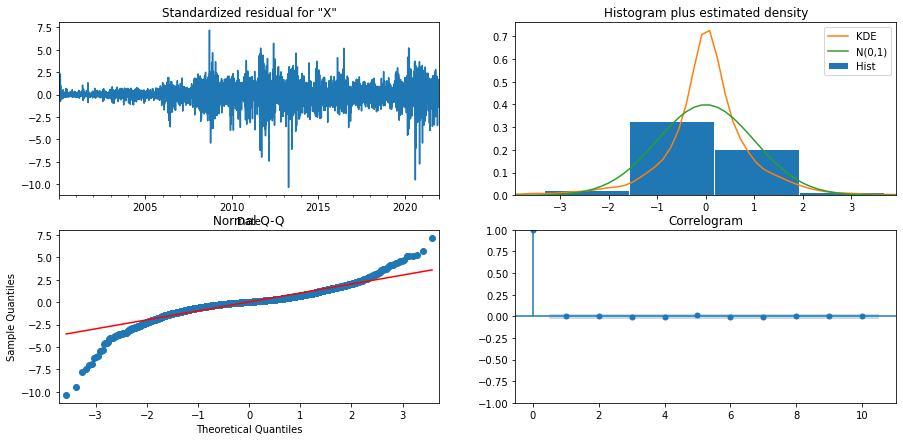

In [20]:
res.plot_diagnostics();

#### FORECASTING

In [21]:
n_forecast = len(exog_test)

predict = res.get_prediction(exog = exog_test, end=best_model.nobs + n_forecast-1)
predictions = predict.predicted_mean
predictions


2000-01-05     201.635755
2000-01-06     280.430713
2000-01-07     281.649920
2000-01-10     282.629082
2000-01-11     282.020197
                 ...     
2022-10-06    1745.056936
2022-10-07    1740.729253
2022-10-10    1730.263963
2022-10-11    1712.313965
2022-10-12    1710.650136
Freq: B, Name: predicted_mean, Length: 5941, dtype: float64

In [22]:
xau_lag['Predicted'] = predictions
forecast = xau_lag[xau_lag[['Predicted']].index.isin(endog_test.index)]

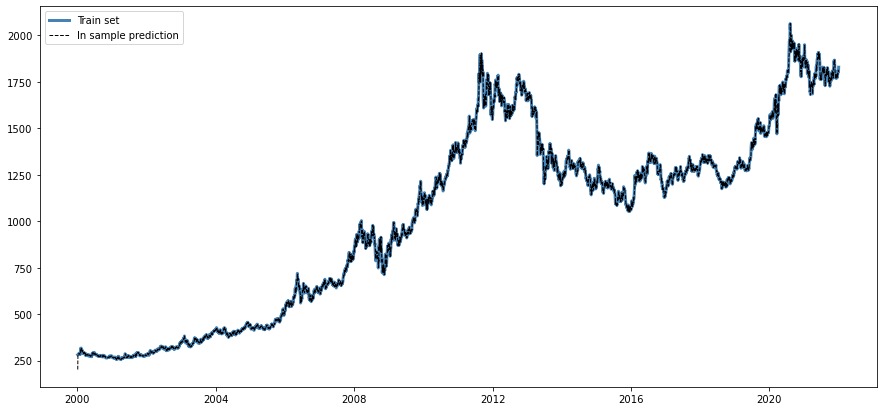

In [23]:
#In-sample ARIMAX forecast

fig, ax = plt.subplots()

ax.plot(xau['XAU_Close'][:'2021'], 'steelblue', label = 'Train set', linewidth = 3)
ax.plot(xau_lag['Predicted'][:'2021'], 'black', linestyle = 'dashed', label = 'In sample prediction', linewidth = 1)

ax.legend(loc = 'upper left')

plt.show()


In [24]:
# In-sample ARIMAX evaluation

r2_ = r2(xau['XAU_Close'][:'2021'], xau_lag['Predicted'][:'2021'])
mse_ = mse(xau['XAU_Close'][:'2021'], xau_lag['Predicted'][:'2021'])
rmse_ = np.sqrt(mse_)

print(f"R2:{r2_}\nMSE: {mse_}\nRMSE: {rmse_}")

R2:0.999455393661319
MSE: 139.81442461109026
RMSE: 11.824314974284567


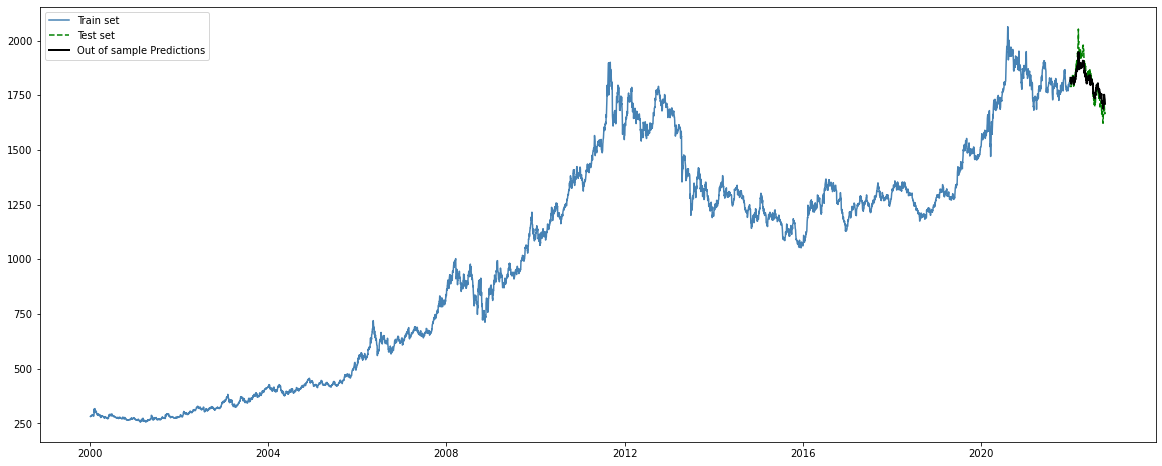

In [25]:
#Out-of-sample ARIMAX forecast (zoomed-out)
plt.rcParams['figure.figsize'] = [20, 8]
fig, ax = plt.subplots()


ax.plot(endog_train, 'steelblue', label = 'Train set')
ax.plot(endog_test, 'green', linestyle = 'dashed', label = 'Test set')
ax.plot(forecast['Predicted'], 'black', linewidth = 2,label = 'Out of sample Predictions')

ax.legend(loc = 'upper left')

plt.show()


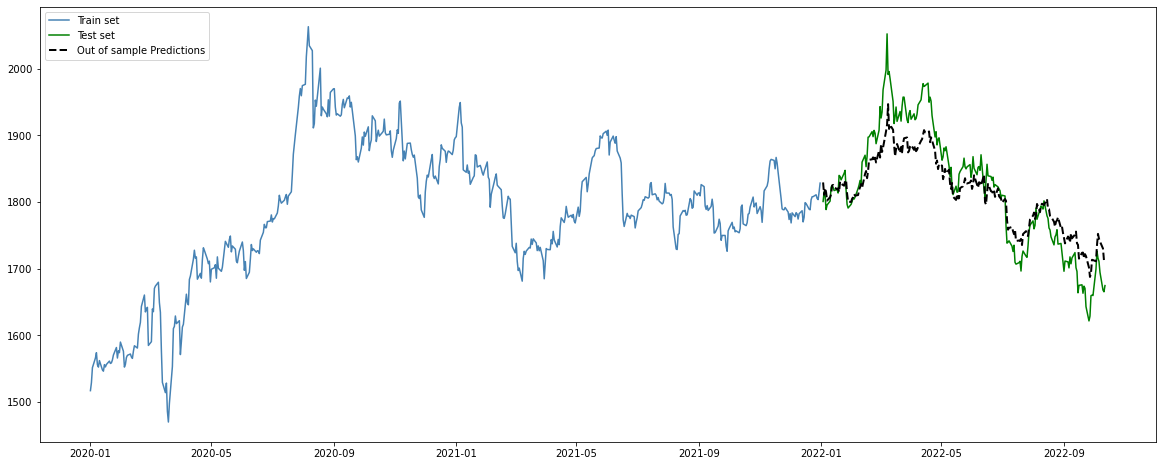

In [26]:
#Out-of-sample ARIMAX forecast (zoomed-in)
plt.rcParams['figure.figsize'] = [20, 8]
fig, ax = plt.subplots()


ax.plot(endog_train['2020':], 'steelblue', label = 'Train set')
ax.plot(endog_test, 'green', label = 'Test set')
ax.plot(forecast['Predicted'], 'black', linestyle = 'dashed', linewidth = 2,label = 'Out of sample Predictions')

ax.legend(loc = 'upper left')

plt.show()

In [28]:
endog_test['Predicted'] = predict.predicted_mean

r2_ = r2(endog_test['XAU_Close'], endog_test['Predicted'])
mse_ = mse(endog_test['XAU_Close'], endog_test['Predicted'])
rmse_ = np.sqrt(mse_)

print(f"R2:{r2_}\nMSE: {mse_}\nRMSE: {rmse_}")

R2:0.8177006521415157
MSE: 1492.6216114174201
RMSE: 38.63446144852313


In [31]:
# Export out-of-sample predictions to CSV
xau_lag.to_csv('ARIMAX_forecast.csv')